# Case: Forecasting event counts


<br>The purpose of this case is to predict the number of events in the test set, given a training dataset on which we could train our model the best possible way. The second part of the task is to determine which of the variables are the most important in making this prediction. This notebook is split into main sections: data exploration, making a baseline model, data engineering, setting up models and training environment, and making the final predictions.

I have received two csv files: `train.csv` and `test.csv` and information that the training dataset consists of 10 explanatory variables and one target variable `y`. It means that it is a supervised learning classification task. There is no further explanation of what the variables stand for, and what kind of event we are going to predict, so the first thing to do is, to explore the data and try to get to know its characteristics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.externals.six import StringIO
from sklearn.metrics import confusion_matrix, auc, classification_report
from sklearn.utils import shuffle
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os     
import lightgbm as lgbm
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
%matplotlib inline

pd.set_option('display.max_columns', 25)
plt.style.use('fivethirtyeight')

In [2]:
train = pd.read_csv('train.csv')

## The data

At first glance at the data, we can see that there are indeed 10 features named `x1, x2, ..., x10` and 1 target variable `y`. 

We can also spot some specific characteristics of these variables:

1. The target variable `y` is binary. It has two possible values: 0 or 1.
2. Features from `x1` to `x6` are of type `float` and features from `x7` to `x10` are integers. 
3. Variables `x7`, `x8`, and `x9` are binary so they have two possible values: 0 or 1. 
4. Variable `x10` consists of integers in range of <-5, 5> so there are 11 possible values for this variable. It seems that this may also be a categorical feature of 11 possible classes.

There are many specific characteristics of features, but the most important thing about this particular dataset is the Target variable `y` and its distribution. After exploring the data we notice that `y` is not evenly distributed, which makes this an unbalanced class problem. The `one` events are much more rare than `zero` events. There are exactly 23,58% of `ones` in the `y` target variable.

This finding is going to be crucial for my approach towards solving this case. We could come up with a 'model' that would output only `0s` and end up with a pretty decent score of around 76,5% on the training set. This is clearly not a good enough approach, as in a case of class unbalance we want our model to flag out the `1s` as they seem to be crucial in solving this problem. In banking terms this problem could be connected with finding some abnormalities in the system, or fraudulent transactions, so we do not want to ignore these observations. When I build the models towards the end of this notebook, I will weigh the classes accordingly to their occurence in the dataset, as I want the models to point these events out, even with the sacrifice of overall accuracy.

In this section, the first thing I do is take a look at the data, and the stats of all the features and the target variable. I plot some of the most interesting findings. The plots are described, right above them in this notebook.

In [3]:
train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.952314,-0.040695,-7.346544,-0.942285,-0.983867,-0.713194,0,1,1,5,0
1,2.013124,1.038736,-3.738993,0.038019,-0.335228,0.280228,0,0,1,-5,0
2,2.095885,-1.876494,-2.017696,0.503276,-0.714093,-0.701864,0,0,1,4,1
3,1.803079,-2.272963,-0.992083,-0.380447,-0.778628,0.325195,0,0,1,-4,0
4,1.988797,-0.356817,0.070304,0.815507,-0.991159,0.825843,1,1,1,-3,0


In [4]:
train.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
count,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000
mean,1.999732,-0.001153,-2.263595,-0.108595,-0.669100,-0.003293,0.246311,0.510033,0.751217,0.005203,0.235813
std,0.099665,0.997809,2.003944,0.568895,0.232749,0.578900,0.430865,0.499903,0.432311,3.165907,0.424509
min,1.567972,-4.346310,-10.158041,-0.999980,-0.999994,-0.999915,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,1.932493,-0.671559,-3.619801,-0.603305,-0.861063,-0.504864,0.000000,0.000000,1.000000,-3.000000,0.000000
50%,1.999401,-0.007800,-2.250145,-0.165733,-0.706248,-0.006716,0.000000,1.000000,1.000000,0.000000,0.000000
75%,2.066539,0.671126,-0.914126,0.361343,-0.515371,0.500940,0.000000,1.000000,1.000000,3.000000,0.000000
max,2.465894,4.673155,6.203320,0.999996,-0.000023,0.999967,1.000000,1.000000,1.000000,5.000000,1.000000


In [5]:
X_train = train.drop('y', axis=1)

y_train = train['y']

In [6]:
X_train.dtypes

x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7       int64
x8       int64
x9       int64
x10      int64
dtype: object

In [7]:
y_train.value_counts()

0    50081
1    15454
Name: y, dtype: int64

### Distribution
This plot shows the distribution of `y` variable. We can clearly see that the classes are unbalanced. There are exactly 23.58% of `1s` and the rest are `0s`.

Text(0.5,1,'Distribution of "0" and "1" events in the training set')

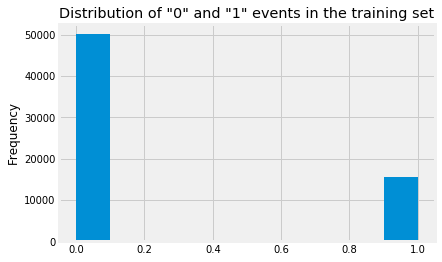

In [8]:
y_train.plot.hist()
plt.title('Distribution of "0" and "1" events in the training set')

In [9]:
print('Percentage of "1" events = ' + str(round(y_train.value_counts()[1]/(y_train.value_counts()[0]+y_train.value_counts()[1])*100, 2))+'%')

Percentage of "1" events = 23.58%


Here I plot the histograms of all the variables from `x1` to `x10`. Variables `x1`, `x2`, and `x3` follow a normal (Gaussian) distribution. Variables `x4` and `x5` are skewed right. `x6` is evenly distributed throughout all of its values. `x7`, `x8`, and `x9` are binary categorical features. `x7` is an unbalanced class - there are more `0s` than `1s`, `x8` is quite evenly distributed between two classes, and `x9` is also unbalanced, but in this case there are more `1s` than `0s`. `x10` variable consists of integers in range of <-5, 5>. The values are distributed evenly among those integers. My first intuition is that it is a categorical feature and we should not treat those values as numerical, meaning that there is no linear relation between the integers (-5 class does not exactly mean that this values is less valued than ie. 2). This finding is going to be verified with the use of logistic regression.

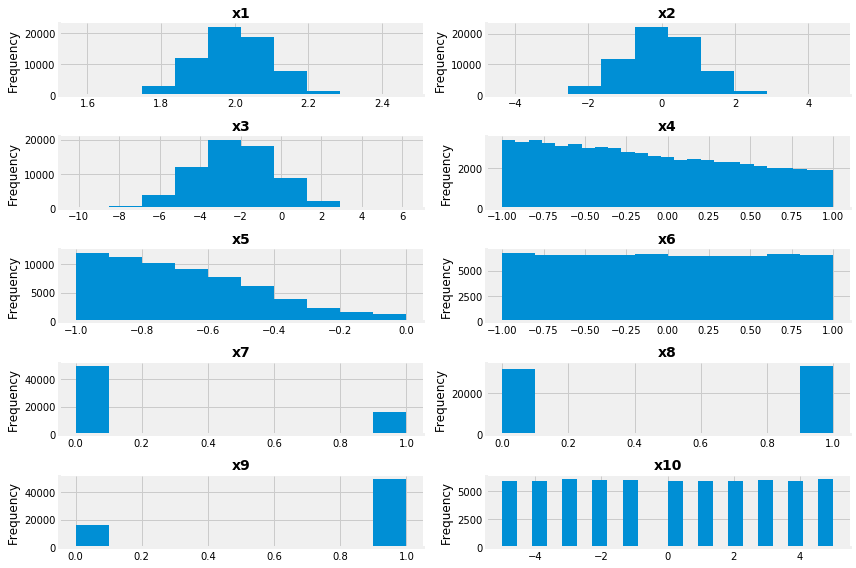

In [10]:
fig = plt.figure(figsize=(12,8))
pattern = (5,2)
x1_ax = plt.subplot2grid(pattern, (0,0))
x2_ax = plt.subplot2grid(pattern, (0,1))
x3_ax = plt.subplot2grid(pattern, (1,0))
x4_ax = plt.subplot2grid(pattern, (1,1))
x5_ax = plt.subplot2grid(pattern, (2,0))
x6_ax = plt.subplot2grid(pattern, (2,1))
x7_ax = plt.subplot2grid(pattern, (3,0))
x8_ax = plt.subplot2grid(pattern, (3,1))
x9_ax = plt.subplot2grid(pattern, (4,0))
x10_ax = plt.subplot2grid(pattern, (4,1))
X_train['x1'].plot.hist(ax=x1_ax)
x1_ax.set_title('x1', fontsize=14, fontweight='bold')
X_train['x2'].plot(ax=x2_ax, kind = 'hist')
x2_ax.set_title('x2', fontsize=14, fontweight='bold')
X_train['x3'].plot.hist(ax=x3_ax)
x3_ax.set_title('x3', fontsize=14, fontweight='bold')
X_train['x4'].plot.hist(ax=x4_ax, bins=25)
x4_ax.set_title('x4', fontsize=14, fontweight='bold')
X_train['x5'].plot.hist(ax=x5_ax)
x5_ax.set_title('x5', fontsize=14, fontweight='bold')
X_train['x6'].plot(ax=x6_ax, kind = 'hist')
x6_ax.set_title('x6', fontsize=14, fontweight='bold')
X_train['x7'].plot.hist(ax=x7_ax)
x7_ax.set_title('x7', fontsize=14, fontweight='bold')
X_train['x8'].plot.hist(ax=x8_ax)
x8_ax.set_title('x8', fontsize=14, fontweight='bold')
X_train['x9'].plot.hist(ax=x9_ax)
x9_ax.set_title('x9', fontsize=14, fontweight='bold')
X_train['x10'].plot.hist(ax=x10_ax, bins=22)
x10_ax.set_title('x10', fontsize=14, fontweight='bold')
sns.despine()
plt.tight_layout()

### Correlations

This plot shows correlations between all the variables and the target. One of the variables stand out amongst others. `x5` has 0.25 correlation with the target, which means there is some linear relation between those two variables. We can expect that in terms of linear models, this variable will have the biggest effect on the prediction. 

Apart from correlations between variables and the target, there are also some relations between the variables. `x5` and `x4` have the strongest negative correlation of -0.21. Also `x3` and `x5` are somewhat correlated with -0.16. `x4` is also correlated with the categorical feature `x8` (-0.18).

We can see that there may be some interesting relations between different variables, but none of those correlations are particularly strong. To capture those relations we will engineer the features further in the notebook.

Text(0.5,1,'Correlation Heatmap')

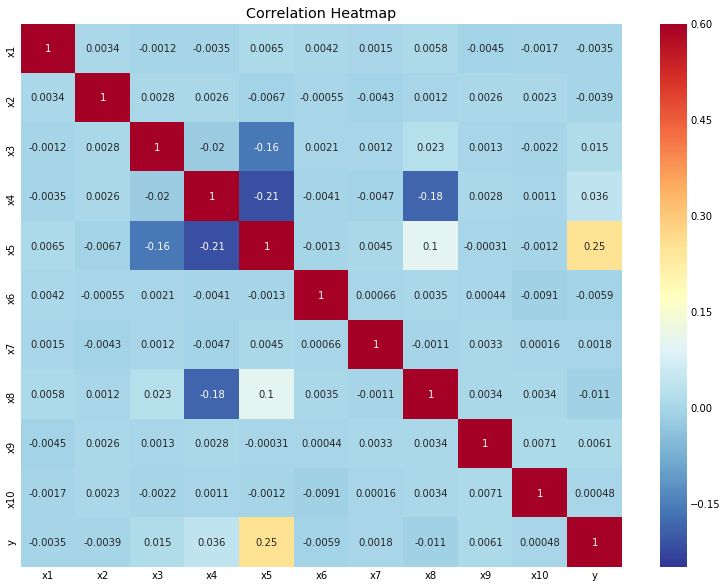

In [11]:
data_corrs = train.corr()

plt.figure(figsize = (12, 10))

sns.heatmap(data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

This plot shows the density of `x5` variable in relation to the target variable. What we can see is that when the target `y` is a `0` the distribution of `x5` is skewed right, and when the target `y` is `1` `x5` follows a normal distribution. In terms of linear models and building a decision tree this a very important finding, as this variable is most likely going to be a starting point and the most imporant feature.

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of x5')

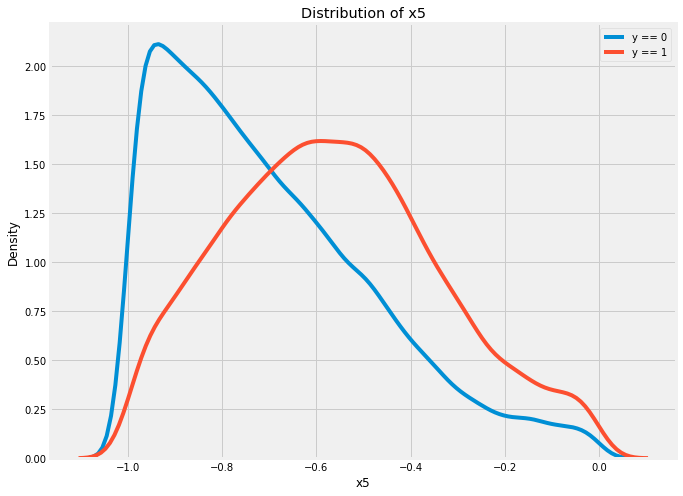

In [12]:
plt.figure(figsize = (10, 8))

sns.kdeplot(train.loc[train['y'] == 0, 'x5'] , label = 'y == 0')

sns.kdeplot(train.loc[train['y'] == 1, 'x5'] , label = 'y == 1')

plt.xlabel('x5'); plt.ylabel('Density'); plt.title('Distribution of x5')

Solving the problem is all about finding some patterns in the data and relations between variables. In this plot we take the three features the most correlated with the target: `x3`, `x4`, and `x5`, and take a look at how they are connected to each other, and the target.

The blue color is connected with the target of value `0` and the red `1`. From this plot we can quite clearly see that the `x3` variable does not give any information about the target value - it follows a normal distribution in both instances (when the targer is 0 and 1). The `x4` give some, little information. The density of `x4` is a little bit skewed right when the target is `0`. I described the relation of `x5` in the previous plot. 

What is more interesting, are the relations between variables, and especially with the `x3` variable. The red dots (`1s` in the target variable) seem to be concentrated around the middle of distribution, and some of the blue dots are more concentrated on the limits of `x3` distribution. This relation may be used in the models we set up at the end.

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.05,'Features: x3, x4 and x5 Pair Plot')

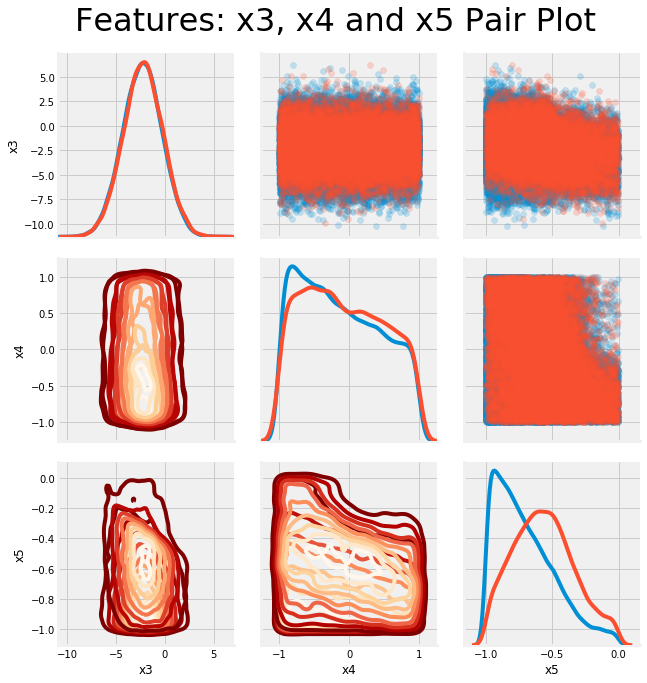

In [13]:
plot_data = train[['y','x3','x4','x5']].copy()

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'y', 
                    vars = [x for x in list(plot_data.columns) if x != 'y'])

grid.map_upper(plt.scatter, alpha = 0.2)

grid.map_diag(sns.kdeplot)

grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Features: x3, x4 and x5 Pair Plot', size = 32, y = 1.05)

### Decision Tree

My next step in exploring the data is setting up a baseline for further predictions. Setting a baseline lets us see what kind of problem we are dealing with, what variables are going to be the most important (at least when dealing the problem linearly) and lastly, it sets a score that we would like to beat in the final part, when making the prediction.

In [14]:
dc_clf = DecisionTreeClassifier(max_depth=3)

In [15]:
dc_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

This graph shows a simple Decision Tree (the max_depth parameter is set to 3 in order to visualise it clearly). The main purpose of this graph is to show what are the most important features for this model. When analysing the relations between variables we spotted that the variable `x5` may be the one that gives the most information to a model, and in terms of a Decision Tree this came true, as the `x5` sits at the top of the tree. The decision threshold for initial branch stands at `x5 <= -0.705`, which is similar to what we had previously found when exploring the density of `x5` in relation to `y`. The second variable used for this Decision Tree is `x4` - the feature that was second most correlated to the target.

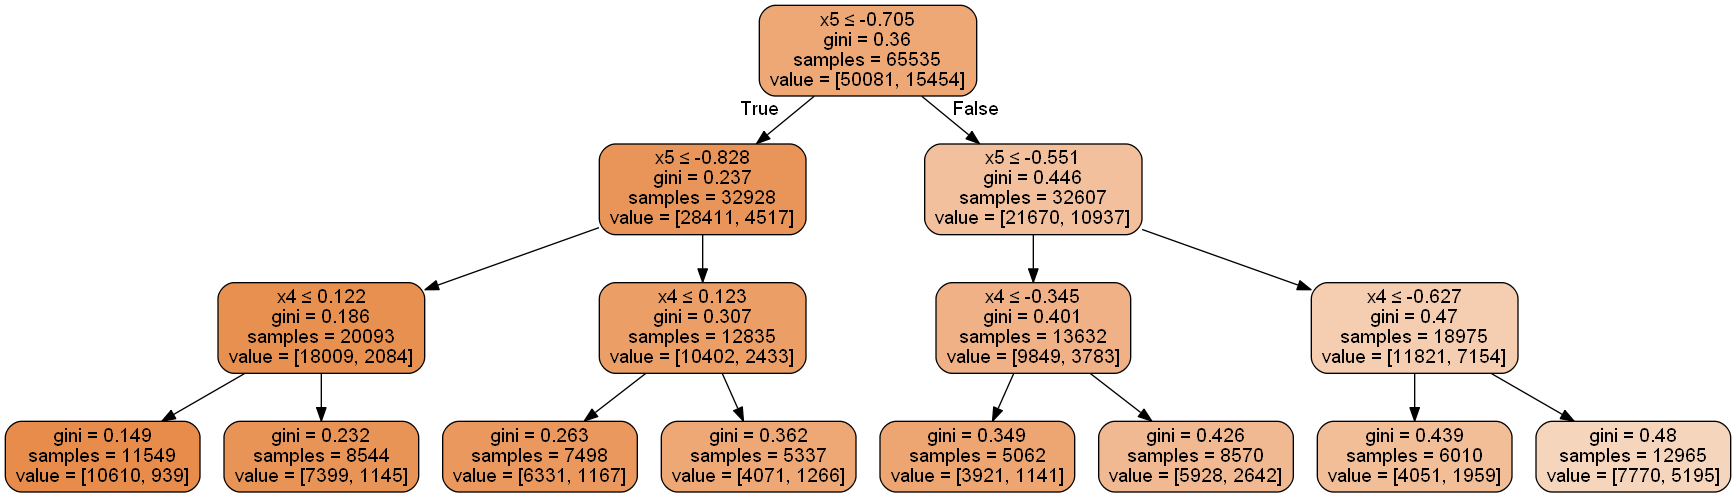

In [16]:
dot_data = StringIO()

export_graphviz(dc_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

The rough score for this simple classifier is 0.76 on the training data.

In [17]:
dc_clf.score(X_train, y_train)

0.7641870756084534

### Logistic Regression

I am going to use Logistic Regression as the basic baseline for the models created at the end. Logistic Regression is one of the most widely used statistical models. As the name suggests it uses a logistic function to model a binary dependent variable, which is exactly what we want to achieve in this case. It is a linear model, and we have established in the data analysis that there are no clear linear relations between the features and the target, so when setting up the model I am not expecting great results.

We are training the model on the entire training dataset, so that it could capture most of the data peculiarities.

In [18]:
lr_clf = LogisticRegression()

In [19]:
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

I have fitted the model, so now the first thing I can do is check the coefficients and check which of the features where the most important for the trained model. I use a simple, but a very good measure of importance, with the data not being scaled before fitting, which is the coeficient multiplied by variable's standard deviation. 

It turns out that, as we could have expected, the `x5` is the most imporant for the model, followed by `x4`, and `x3`. The other variables seem to give absolutely no information to the model.

In [20]:
for i in range(10):
    importance = np.std(X_train)[i] * lr_clf.coef_[0][i]
    print('x'+str(i+1)+' importance is: '+str(round(importance,2)))

x1 importance is: -0.01
x2 importance is: -0.01
x3 importance is: 0.17
x4 importance is: 0.25
x5 importance is: 0.68
x6 importance is: -0.01
x7 importance is: 0.0
x8 importance is: -0.06
x9 importance is: 0.02
x10 importance is: 0.0


Below is the confusion matrix of the Logistic Regression predictions and actual values from the training set. The columns are predictions, the rows are actual values. The model predicted 63346 `0s` and 2189 `1s`, which is exactly what we were worried about when describing the finding of target classes being unbalanced. The model 'decides' to output mostly `0s` as it gives it the best accuracy. We can see that it comes with the price of misclassifying 14537 `1s` as `0s`. The fact that it gives such poor results even on the dataset that it was trained on, is valuable information. This problem is by no means easy, and we will have to use some more advanced techniques to boost these predictions accuracies up.

In [21]:
pd.DataFrame(confusion_matrix(y_train, lr_clf.predict(X_train)), columns=['0','1'])

,0,1
0,48809,1272
1,14537,917


When we print out the classification report we can see the actual numbers of this classification. The numbers for predicting the `1` are really poor. The recall for `1` is 0.06 (the model predicted correctly 917 `1s` out of 15454 total `1s` in the training set). This results only confirms that our focus should be placed on improving especially the recall results.

In [22]:
print(classification_report(y_train, lr_clf.predict(X_train)))

             precision    recall  f1-score   support

          0       0.77      0.97      0.86     50081
          1       0.42      0.06      0.10     15454

avg / total       0.69      0.76      0.68     65535



In [23]:
lr_clf.score(X_train, y_train)

0.7587701228351262

### Test set

Before doing any feature engineering, we have to load the test set, because any change applied to the training set has to be applied to the test set also.

The test set looks very similar to the training set. It also consists of 10 variables. The difference is that it does not include the target variable `y`. We also take a look at the statistics of the test variables and the numbers look very similar. The variables have values between similar ranges, and at first look the mean and standard deviation values are also very similar.

However, if we look closely we can see that the `x3`, `x4`, and `x5` mean values are a little bit different. 

1. `x3` mean in the train set: -2.26, in the test set: -1.72.
2. `x4` mean in the train set: -0.11, in the test set: 0.11.
3. `x5` mean in the train set: -0.67, in the test set: -0.33.

This finding is very important, and gives us a simple idea of what the results might look like for the test set. We established that linearly the `x5` variable is the most decisive, and when it takes values in its lower range it most of the time corresponds to a `0` value in the `y` target. So knowing that in the test set, the mean value of this variable is much bigger it can suggest that the test set's `y` target is going to be populated more with `1s` than `0s`.

In [24]:
test = pd.read_csv('test.csv')

In [25]:
test.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
count,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000
mean,1.999509,0.004369,-1.728251,0.112366,-0.330488,0.003722,0.249409,0.486961,0.750393,0.014755
std,0.099935,1.002927,1.957186,0.563570,0.234267,0.576672,0.432674,0.499834,0.432789,3.158615
min,1.585052,-4.573690,-10.560751,-0.999985,-0.999985,-0.999979,0.000000,0.000000,0.000000,-5.000000
25%,1.932290,-0.670908,-3.059705,-0.341363,-0.480648,-0.494189,0.000000,0.000000,1.000000,-3.000000
50%,1.999690,0.002016,-1.731881,0.166166,-0.286782,0.002437,0.000000,0.000000,1.000000,0.000000
75%,2.066511,0.681991,-0.413201,0.600775,-0.140729,0.503319,0.000000,1.000000,1.000000,3.000000
max,2.409587,4.102095,6.400400,0.999985,-0.000032,0.999974,1.000000,1.000000,1.000000,5.000000


This plot shows exactly what we found out about about the mean of `x5`. In the training set the `x5` was skewed right, in the test set it skewed left, which will for sure have some effect on the results.

Text(0.5,1,'x5 distribution in the test set')

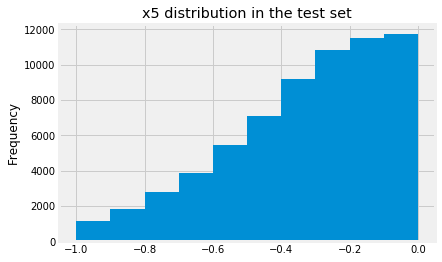

In [75]:
test['x5'].plot.hist()
plt.title('x5 distribution in the test set')

## Feature Engineering

As we have spotted earlier there seems to be some work to do to with the features in order to get as much information from them as possible. The model predictions are going to be as good, as the features fed into it.

The first thing I do is encode the `x10` variable. There are 11 categories which take the form of integers from -5 to 5. After the classes are initially being encoded I perform a One Hot Encoding, which splits the `x10` variable into 11 seperate features, with zeros in all of them, but the one with observation's encoding. It means that for example: if the class of the `x10` variable was `-5` it puts a `1` in `x10_0` feature and fill the rest of `x10` created features with zeros.

The second change we apply to the original dataset is creating Polynomial Features with the degree of 2. This transformation creates additional features of multiplication of features by each other and squaring the original feature. The purpose of this activity is to capture relations between the features by joining them by multiplication. We also square the features which enables the model to find non-linear relations in a feature. I apply this function only to numerical features, as applying it to categorical features would not be very helpful. From original 6 numerical features we end up with 27 numerical features. And from original 4 categorical features we end up with 14 categorical features. The total numbers of features we feed to the models are 41.

In [26]:
encoder = LabelEncoder()

In [27]:
le_count = 0
for col in X_train:
    if len(list(X_train[col].unique())) == 11:

        encoder.fit(X_train[col])

        X_train[col] = encoder.transform(X_train[col])

        le_count += 1
print('%d columns were label encoded.' % le_count)

le_count = 0
for col in test:
    if len(list(test[col].unique())) == 11:

        encoder.fit(test[col])

        test[col] = encoder.transform(test[col])

        le_count += 1
print('%d columns were label encoded.' % le_count)

1 columns were label encoded.
1 columns were label encoded.


In [28]:
X_train['x10']=X_train['x10'].astype('category',inplace=True)

test['x10']=test['x10'].astype('category',inplace=True)

In [29]:
X_train = pd.get_dummies(X_train)

test = pd.get_dummies(test)

In [30]:
test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10_0,x10_1,x10_2,x10_3,x10_4,x10_5,x10_6,x10_7,x10_8,x10_9,x10_10
0,1.883097,0.357933,-2.990392,0.327230,-0.445492,-0.962282,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,2.005020,-0.609200,-4.955270,0.714339,-0.303447,0.038047,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,2.013038,0.416132,-0.835807,0.605859,-0.109376,-0.010054,1,0,1,0,0,1,0,0,0,0,0,0,0,0
3,1.998148,-1.464290,-2.124962,0.181642,-0.608423,-0.393744,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,2.032958,1.771806,-4.855968,0.173707,-0.710363,0.428251,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [31]:
pf = PolynomialFeatures(degree=2, interaction_only=False,  include_bias=False)

In [32]:
X_train_poly = pf.fit_transform(X_train[['x1','x2','x3','x4','x5','x6']])

test_poly = pf.fit_transform(test[['x1','x2','x3','x4','x5','x6']])

In [33]:
X_train_poly_df = pd.DataFrame(X_train_poly, columns=pf.get_feature_names(input_features=['x1','x2','x3','x4','x5','x6']))

test_poly_df = pd.DataFrame(test_poly, columns=pf.get_feature_names(input_features=['x1','x2','x3','x4','x5','x6']))

In [34]:
X_train_poly_df.head()

,x1,x2,x3,x4,x5,x6,x1^2,x1 x2,x1 x3,x1 x4,x1 x5,x1 x6,...,x2 x5,x2 x6,x3^2,x3 x4,x3 x5,x3 x6,x4^2,x4 x5,x4 x6,x5^2,x5 x6,x6^2
0,1.952314,-0.040695,-7.346544,-0.942285,-0.983867,-0.713194,3.811532,-0.079450,-14.342763,-1.839636,-1.920818,-1.392379,...,0.040039,0.029024,53.971703,6.922536,7.228023,5.239512,0.887901,0.927083,0.672032,0.967995,0.701688,0.508646
1,2.013124,1.038736,-3.738993,0.038019,-0.335228,0.280228,4.052668,2.091105,-7.527057,0.076537,-0.674856,0.564134,...,-0.348213,0.291083,13.980072,-0.142152,1.253415,-1.047772,0.001445,-0.012745,0.010654,0.112378,-0.093940,0.078528
2,2.095885,-1.876494,-2.017696,0.503276,-0.714093,-0.701864,4.392734,-3.932917,-4.228859,1.054808,-1.496656,-1.471026,...,1.339991,1.317044,4.071098,-1.015457,1.440822,1.416148,0.253286,-0.359385,-0.353231,0.509928,0.501196,0.492613
3,1.803079,-2.272963,-0.992083,-0.380447,-0.778628,0.325195,3.251094,-4.098333,-1.788804,-0.685976,-1.403929,0.586352,...,1.769794,-0.739155,0.984229,0.377435,0.772464,-0.322620,0.144740,0.296227,-0.123719,0.606262,-0.253206,0.105752
4,1.988797,-0.356817,0.070304,0.815507,-0.991159,0.825843,3.955315,-0.709636,0.139821,1.621878,-1.971214,1.642435,...,0.353662,-0.294675,0.004943,0.057334,-0.069683,0.058060,0.665052,-0.808297,0.673481,0.982396,-0.818542,0.682017


In [35]:
X_train = pd.concat([X_train_poly_df, X_train.drop(['x1','x2','x3','x4','x5','x6'],axis=1)], axis=1)

test = pd.concat([test_poly_df, test.drop(['x1','x2','x3','x4','x5','x6'],axis=1)], axis=1)

Before creating the models we take a quick look at the correlations of the features that were engineered. `x5` squared has the biggest negative correlation with the target, with `x3 * x5` in the second place. For positive correlations we still see that `x5` has the strongest correlation, but a close second is `x1 * x5`. We can see that adding new features and especially incorporating the multiplications between features might add some information to our predictions.

In [36]:
pd.concat([y_train, X_train], axis=1).corr()['y'].sort_values()

x5^2     -0.260137
x3 x5    -0.113765
x4 x5    -0.061769
x3 x4    -0.034064
x4^2     -0.017313
x3^2     -0.011429
x8       -0.010717
x10_7    -0.006624
x10_5    -0.006090
x6       -0.005943
x1 x6    -0.005838
x10_8    -0.005651
x10_0    -0.004583
x2       -0.003945
x1 x2    -0.003764
x1^2     -0.003666
x1       -0.003523
x6^2     -0.002812
x2^2     -0.002544
x10_2    -0.000857
x4 x6     0.000271
x2 x6     0.000341
x10_10    0.000383
x2 x3     0.001077
x10_6     0.001232
x10_3     0.001639
x7        0.001794
x2 x4     0.002219
x10_4     0.002534
x3 x6     0.003436
x2 x5     0.004381
x9        0.006127
x5 x6     0.006886
x10_1     0.007411
x10_9     0.010619
x1 x3     0.014769
x3        0.014828
x4        0.035847
x1 x4     0.036051
x1 x5     0.249162
x5        0.251544
y         1.000000
Name: y, dtype: float64

Before feeding the data to the KFold algorithm and splitting the data into 4 folds I make sure that the data is randomized by performing a shuffle on the training dataframe.

In [37]:
df = pd.concat([y_train, X_train],axis=1)

In [38]:
df_r = shuffle(df)

In [39]:
df_r.head()

,y,x1,x2,x3,x4,x5,x6,x1^2,x1 x2,x1 x3,x1 x4,x1 x5,...,x9,x10_0,x10_1,x10_2,x10_3,x10_4,x10_5,x10_6,x10_7,x10_8,x10_9,x10_10
24315,0,2.002011,0.558039,-2.638190,0.738728,-0.772174,0.365466,4.008047,1.117201,-5.281685,1.478942,-1.545901,...,1,1,0,0,0,0,0,0,0,0,0,0
10427,1,2.094281,-0.227873,-1.770234,0.749470,-0.437735,0.704423,4.386015,-0.477231,-3.707369,1.569600,-0.916740,...,0,0,0,1,0,0,0,0,0,0,0,0
41547,1,2.116065,0.396195,-4.115309,0.125765,-0.375229,-0.774326,4.477729,0.838375,-8.708260,0.266126,-0.794010,...,0,0,0,0,0,0,0,0,0,1,0,0
40844,0,2.210099,-0.119404,-3.680039,0.450867,-0.679633,0.639012,4.884538,-0.263894,-8.133252,0.996460,-1.502056,...,0,0,0,0,0,1,0,0,0,0,0,0
61509,0,1.935325,1.104827,-3.111680,0.305852,-0.766559,-0.006523,3.745485,2.138200,-6.022113,0.591923,-1.483541,...,1,0,0,0,0,1,0,0,0,0,0,0


In [40]:
df_r.reset_index(inplace=True, drop=True)

In [42]:
X_train = df_r.drop('y',axis=1)
y_train = df_r['y']

In [43]:
y_train.dtypes

dtype('int64')

In [44]:
X_train[['x7', 'x8', 'x9', 'x10_0', 'x10_1', 'x10_2','x10_3','x10_4','x10_5','x10_6','x10_7','x10_8','x10_9','x10_10']]=X_train[['x7', 'x8', 'x9', 'x10_0', 'x10_1', 'x10_2','x10_3','x10_4','x10_5','x10_6','x10_7','x10_8','x10_9','x10_10']].astype('category', inplace=True)

In [45]:
test[['x7', 'x8', 'x9', 'x10_0', 'x10_1', 'x10_2','x10_3','x10_4','x10_5','x10_6','x10_7','x10_8','x10_9','x10_10']]=test[['x7', 'x8', 'x9', 'x10_0', 'x10_1', 'x10_2','x10_3','x10_4','x10_5','x10_6','x10_7','x10_8','x10_9','x10_10']].astype('category', inplace=True)

In [46]:
test.head()

,x1,x2,x3,x4,x5,x6,x1^2,x1 x2,x1 x3,x1 x4,x1 x5,x1 x6,...,x9,x10_0,x10_1,x10_2,x10_3,x10_4,x10_5,x10_6,x10_7,x10_8,x10_9,x10_10
0,1.883097,0.357933,-2.990392,0.327230,-0.445492,-0.962282,3.546053,0.674023,-5.631197,0.616205,-0.838904,-1.812071,...,1,1,0,0,0,0,0,0,0,0,0,0
1,2.005020,-0.609200,-4.955270,0.714339,-0.303447,0.038047,4.020107,-1.221458,-9.935418,1.432264,-0.608418,0.076286,...,1,0,0,0,0,0,0,0,1,0,0,0
2,2.013038,0.416132,-0.835807,0.605859,-0.109376,-0.010054,4.052323,0.837689,-1.682511,1.219617,-0.220178,-0.020240,...,1,0,0,1,0,0,0,0,0,0,0,0
3,1.998148,-1.464290,-2.124962,0.181642,-0.608423,-0.393744,3.992595,-2.925868,-4.245988,0.362947,-1.215720,-0.786760,...,0,0,0,0,0,0,0,0,0,0,1,0
4,2.032958,1.771806,-4.855968,0.173707,-0.710363,0.428251,4.132919,3.602007,-9.871980,0.353139,-1.444139,0.870616,...,1,0,0,0,0,1,0,0,0,0,0,0


In [47]:
y_train = y_train.astype('category')

## Final models

The data preprocessing is over, and we can begin the final part of the project - modelling the data. We have engineered some new features in order for our models to make the most of the available data. For the final modelling process I picked two models:

1. LightGBM model
2. Neural Network model

Why these models? The LightGBM is a gradient boosting framework based on a decision tree. We have previously seen that a decision tree might get good results, taking the fact that there are some patterns in certain variables that seem not to be linear and a decision tree algorithm might be the way to go. Why gradient boosting algorithm? In many applications gradient boosting techniques performed the best in terms of classification problems. The idea behind gradient boosting is taking an ensemble of weak models and producing a strong prediction model out of it. There are some gradient boosting algorithms that are very popular like: XGBoost or CatBoost amongst others. I chose LightGBM because it is computationally not very expensive, because it builds the decision trees leaf-wise, on contrary to other models which build models level-wise, and becuase it seems to produce the best predictions.

It was not hard to chose Neural Network algorithm for this problem. There did not seem to be many linear relations between the data, and the Neural Network might get the best out of the features with all the mathematical operations done to the input tensors inside of the network. The network I built here is not very complicated: it consists of one input Dense layer with 100 nodes, one hidden Dense layer with 100 nodes, and one output Dense layer with 1 output node. The activation for the first two layers are 'relu', and I picked 'sigmoid' activation function at the output layer because we are making a binary classification. Before running these models I was betting that the Neural Network would produce the best results.

I picked two models to make the predictions in order to make the results as reasonable as possible. But apart from making predictions with two models I also decided to perform it with a KFolds cross validation. I made the models to train on 4 different folds. In each fold I pick the iteration that performed the best on the validation data and make a prediction on the test set, and write the prediction probabilities to a pandas DataFrame. So when the training process stops, the training loop outputs the DataFrame with 8 different predictions for each data observation in the test set. Both models, also take into consideration the fact that the dataset target variable is unbalanced - they are penalized more for misclassifying the `1` event.

After each model is being trained I make a prediction on the current validation set and print out the classification report. As we can see, the Neural Network gets the better f1-score on each of the folds. The results of Neural Network average around 0.71 f1-score, and for the LightGBM it is around 0.65. What is interesting the LGBM gets better recall score for classsifying `1s` but worse precison scores than Neural Network, and also much worse recall for classifying `0s`.

In [48]:
kf = KFold(4)
fold=0
results = pd.DataFrame()
feature_names = X_train.columns
feature_importance_values = np.zeros(len(feature_names))

In [49]:
for train_index, test_index in kf.split(X_train, y_train):
    model = None
    gb_model = None
    fold += 1
    print('Training models on fold no. '+ str(fold))
    path_checkpoint = 'checkpoint_'+str(fold)+'.keras'

    X_tr, X_val = X_train.loc[train_index], X_train.loc[test_index]
    y_tr, y_val = y_train.loc[train_index], y_train.loc[test_index]

    validation_data = (X_val, y_val)
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
    callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
    callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
    
    gb_model = lgbm.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   learning_rate = 0.1,
                                   class_weight='balanced',
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
    gb_model.fit(X_tr, y_tr, eval_metric = 'auc', 
                  eval_set = [(X_val, y_val)],
                  eval_names = ['valid'],
                  early_stopping_rounds = 200, verbose = 200)
    best_iter = gb_model.best_iteration_
    gb_y_pred = gb_model.predict_proba(test, num_iteration = best_iter)[:,1]
    val_pred = gb_model.predict(X_val, num_iteration = best_iter)
    print('Fold ' + str(fold)+ ' LGBM:\n'+classification_report(y_val,val_pred))
    results['LGBM_fold_'+str(fold)] = gb_y_pred
    feature_importance_values += gb_model.feature_importances_ / kf.n_splits

    model = Sequential()

    model.add(Dense(units=100, input_dim=X_train.shape[1], activation='relu'))
    
    model.add(Dense(units = 100, activation='relu', name='layer_1'))

    #model.add(Dense(units = 200, activation='relu', name='layer_2'))

    #model.add(Dense(units = 401, activation='relu', name='layer_3'))

    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=0.01)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_tr, y_tr,epochs=20, validation_data=validation_data, callbacks=callbacks, class_weight={0:1, 1:2.1})
    
    try:
        model.load_weights(path_checkpoint)
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)
    result = model.evaluate(x=X_train,
                            y=y_train)
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))
    nn_y_pred = model.predict(test)
    val_pred = model.predict(X_val)
    val_pred = np.where(val_pred >=0.5, 1, 0)
    print('Fold ' + str(fold)+ ' NN:\n'+classification_report(y_val,val_pred))
    results['NN_fold_'+str(fold)] = pd.Series(nn_y_pred[:,0])

Training models on fold no. 1
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.68833
Early stopping, best iteration is:
[24]	valid's auc: 0.697764


C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 1 LGBM:
             precision    recall  f1-score   support

          0       0.86      0.60      0.71     12512
          1       0.35      0.69      0.47      3872

avg / total       0.74      0.63      0.65     16384

Train on 49151 samples, validate on 16384 samples
Epoch 1/20
49151/49151 [==============================] - 10s 195us/step - loss: 0.7974 - acc: 0.7008 - val_loss: 0.5555 - val_acc: 0.6972

Epoch 00001: val_loss improved from inf to 0.55551, saving model to checkpoint_1.keras
Epoch 2/20
49151/49151 [==============================] - 9s 174us/step - loss: 0.7835 - acc: 0.6912 - val_loss: 0.5501 - val_acc: 0.6967

Epoch 00002: val_loss improved from 0.55551 to 0.55006, saving model to checkpoint_1.keras
Epoch 3/20
49151/49151 [==============================] - 9s 176us/step - loss: 0.7773 - acc: 0.6956 - val_loss: 0.5620 - val_acc: 0.6970

Epoch 00003: val_loss did not improve from 0.55006

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000999999977648

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 2 LGBM:
             precision    recall  f1-score   support

          0       0.87      0.60      0.71     12498
          1       0.35      0.70      0.47      3886

avg / total       0.75      0.63      0.65     16384

Train on 49151 samples, validate on 16384 samples
Epoch 1/20
49151/49151 [==============================] - 10s 199us/step - loss: 0.7979 - acc: 0.7007 - val_loss: 0.5647 - val_acc: 0.6882

Epoch 00001: val_loss improved from inf to 0.56473, saving model to checkpoint_2.keras
Epoch 2/20
49151/49151 [==============================] - 9s 177us/step - loss: 0.7813 - acc: 0.7006 - val_loss: 0.5836 - val_acc: 0.6586

Epoch 00002: val_loss did not improve from 0.56473

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 3/20
49151/49151 [==============================] - 9s 181us/step - loss: 0.7696 - acc: 0.6970 - val_loss: 0.5397 - val_acc: 0.7077

Epoch 00003: val_loss improved from 0.56473 to 0.53969, saving model to checkpoint_2.

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 3 LGBM:
             precision    recall  f1-score   support

          0       0.87      0.60      0.71     12558
          1       0.35      0.71      0.47      3826

avg / total       0.75      0.62      0.65     16384

Train on 49151 samples, validate on 16384 samples
Epoch 1/20
49151/49151 [==============================] - 10s 200us/step - loss: 0.8011 - acc: 0.6920 - val_loss: 0.5858 - val_acc: 0.6867

Epoch 00001: val_loss improved from inf to 0.58577, saving model to checkpoint_3.keras
Epoch 2/20
49151/49151 [==============================] - 9s 177us/step - loss: 0.7826 - acc: 0.6870 - val_loss: 0.5385 - val_acc: 0.7076

Epoch 00002: val_loss improved from 0.58577 to 0.53851, saving model to checkpoint_3.keras
Epoch 3/20
49151/49151 [==============================] - 9s 177us/step - loss: 0.7786 - acc: 0.6913 - val_loss: 0.5289 - val_acc: 0.7310

Epoch 00003: val_loss improved from 0.53851 to 0.52888, saving model to checkpoint_3.keras
Epoch 4/20
49151/49151 [===========

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 4 LGBM:
             precision    recall  f1-score   support

          0       0.87      0.60      0.71     12513
          1       0.35      0.70      0.47      3870

avg / total       0.74      0.62      0.65     16383

Train on 49152 samples, validate on 16383 samples
Epoch 1/20
49152/49152 [==============================] - 10s 204us/step - loss: 0.7979 - acc: 0.6990 - val_loss: 0.6389 - val_acc: 0.6175

Epoch 00001: val_loss improved from inf to 0.63888, saving model to checkpoint_4.keras
Epoch 2/20
49152/49152 [==============================] - 9s 178us/step - loss: 0.7801 - acc: 0.7017 - val_loss: 0.5342 - val_acc: 0.7334

Epoch 00002: val_loss improved from 0.63888 to 0.53416, saving model to checkpoint_4.keras
Epoch 3/20
49152/49152 [==============================] - 9s 179us/step - loss: 0.7770 - acc: 0.7017 - val_loss: 0.5748 - val_acc: 0.6894

Epoch 00003: val_loss did not improve from 0.53416

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000999999977648

The nice thing about LGBM framework is that we can get the idea of which features the algorithm found the most important with feature_importance method. In the KFold loop I collected the importances from each fold and below is the plot of the importances. The model put `x8` categorical feature as the most important, `x3 * x5` as the second, and `x5` as the third, which is quite different from we found earlier with linear correlations.

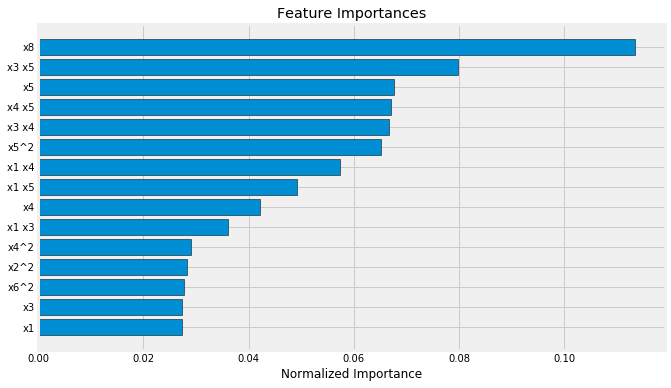

In [50]:
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

df = feature_importances.sort_values('importance', ascending = False).reset_index()
df['importance_normalized'] = df['importance'] / df['importance'].sum()
plt.figure(figsize = (10, 6))
ax = plt.subplot()

ax.barh(list(reversed(list(df.index[:15]))), 
        df['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')

ax.set_yticks(list(reversed(list(df.index[:15]))))
ax.set_yticklabels(df['feature'].head(15))

plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

It is also good to see how the LightGBM draws the trees. It is growing the trees leaf-wise which is visible in the plot, as the tree is getting wider and it is not gaining many levels.

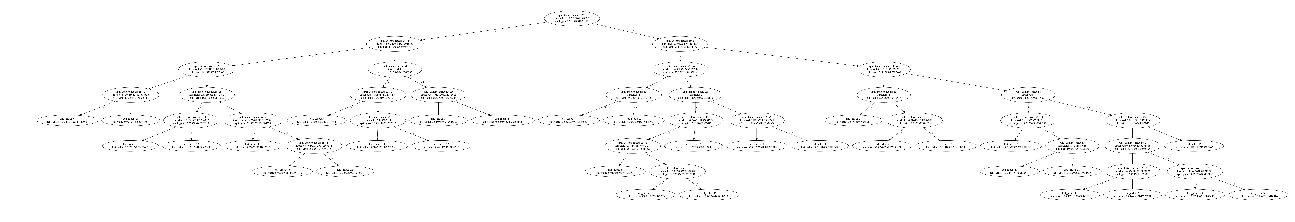

In [80]:
ax = lgbm.plot_tree(gb_model, tree_index=20, figsize=(20, 8), show_info=['split_gain'])
plt.show()

## Predictions

The result of the modelling in KFold loop of 4 folds in our case is a dataframe containing 8 probabilites for each of the observations in the test set. 4 probabilites come from the LGBM model and 4 from the Neural Network. To determine the final prediction I divide the scores by the number of folds, and add the numbers for LGBM and NN. So from 8 probabilities I end up with 2 - one for LGBM and one for NN. 

To come up with the final prediction I apply weights to the predictions made by each model according to the average f1-score achieved by these two models. The average score for LGBM is 0.65 and for the Neural Network it is 0.71. I multiply the prediction probabilities by the according weights and the two prediction probabilities together to come up with the final prediction probability.

The final step is to assign a `0` or a `1` to each observation. I assign a `0` to any probability that is below 0.5 and a `1` to any probability that is higher than 0.5.

The mix of 8 different models prediction produce the following result: the predicted number of `1` events is: 52411, and the predicted number of `0` events is: 13124. So according to the predictions the `1` event is much more common and at around of 80% of the test set. The numbers are quite the opposite to the ones from the train set (0: 50081, 1: 15454) and `1` events at about 23.58%.

In [51]:
results.head()

,LGBM_fold_1,NN_fold_1,LGBM_fold_2,NN_fold_2,LGBM_fold_3,NN_fold_3,LGBM_fold_4,NN_fold_4
0,0.687231,0.574428,0.683930,0.564870,0.656587,0.512545,0.696902,0.501864
1,0.681631,0.586005,0.691891,0.609236,0.678854,0.619188,0.687058,0.549357
2,0.685647,0.595669,0.703235,0.613346,0.688493,0.621128,0.695105,0.595868
3,0.637774,0.592596,0.615310,0.491408,0.610718,0.481343,0.631442,0.493217
4,0.405369,0.352272,0.470971,0.285758,0.405208,0.342144,0.416836,0.341837


In [52]:
r = results/kf.n_splits

lgbm_probability = r['LGBM_fold_1'] + r['LGBM_fold_2'] + r['LGBM_fold_3'] + r['LGBM_fold_4']

nn_probability = r['NN_fold_1'] + r['NN_fold_2'] + r['NN_fold_3'] + r['NN_fold_4']

lgbm_weight = 0.5/(0.71+0.65)
nn_weight = 0.71/(0.71+0.65)

predictions = lgbm_probability*lgbm_weight + nn_probability*nn_weight

In [53]:
print('Number of "1" events in the test set: ' + str(np.where(predictions >=0.5)[0].shape[0]))

Number of "1" events in the test set: 52411


In [55]:
test_set = pd.read_csv('test.csv')
test_set.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,1.883097,0.357933,-2.990392,0.327230,-0.445492,-0.962282,1,1,1,-5
1,2.005020,-0.609200,-4.955270,0.714339,-0.303447,0.038047,0,0,1,2
2,2.013038,0.416132,-0.835807,0.605859,-0.109376,-0.010054,1,0,1,-3
3,1.998148,-1.464290,-2.124962,0.181642,-0.608423,-0.393744,0,1,0,4
4,2.032958,1.771806,-4.855968,0.173707,-0.710363,0.428251,0,0,1,-1


In [64]:
test_with_preds = pd.concat([test_set, pd.Series(np.where(predictions >= 0.5, 1, 0), name='y_pred')], axis=1)

In [69]:
test_with_preds.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y_pred
0,1.883097,0.357933,-2.990392,0.327230,-0.445492,-0.962282,1,1,1,-5,1
1,2.005020,-0.609200,-4.955270,0.714339,-0.303447,0.038047,0,0,1,2,1
2,2.013038,0.416132,-0.835807,0.605859,-0.109376,-0.010054,1,0,1,-3,1
3,1.998148,-1.464290,-2.124962,0.181642,-0.608423,-0.393744,0,1,0,4,0
4,2.032958,1.771806,-4.855968,0.173707,-0.710363,0.428251,0,0,1,-1,0


In [68]:
test_with_preds['y_pred'].value_counts()

1    52411
0    13124
Name: y_pred, dtype: int64

In [76]:
test_with_preds.to_csv('test_pred.csv')

## Conclusion

In this project we go through each step of Data Science workflow. First thing we do is load the datasets and explore the data in order to find some insights that would enable us to make the predictions. We find that there are some relations between different variables and spend some time on engineering new features that would give additional information to the models.

We set up a baseline model using Logistic Regression and observe that such model would fail in making predictions even on the same dataset it was trained on. The problem is that the target variable `y` is a binary variable with unbalanced classes - there are more `0s` than `1s` - and the model outputs mostly `0s` which makes the model quite good at accuracy, but fails completely in finding `1s`. When setting up the models used for final prediction, I made sure that the models took this class unbalance into consideration.

The two models produced 8 different predictions for the test set target variable. After weighing all of the predictions accordingly to the scores obtained in the f1-score I come up with the final prediction. According to predictions made by the models I used to solve this case, there are 52411 `1` events in the test set, and 13124 `0` events. This kind of distribution is the oppostite of the distribution found in the training set. We somehow, predicted that this might be the case when looking at the distribution of the `x5` variable, which was the most important feature and it was skewed in the opposite direction in the test set.

The project has been quite interesting and gave a lot of freedom in performing the task. The results on the f1-score of the models are not perfect and maybe we could improve their performance by tuning the parameters or by performing some further feature engineering. Nevertheless, the initial assumption of making the models predict the less frequent events has been fufilled. Moreover, we managed to find and visualize the features that had the biggest influence on the target variable which was the second part of the task, and set up two cross validated models to come up with the final prediction.

Thank you for reading this notebook!

Piotr Gloger